In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
from datetime import date
import time

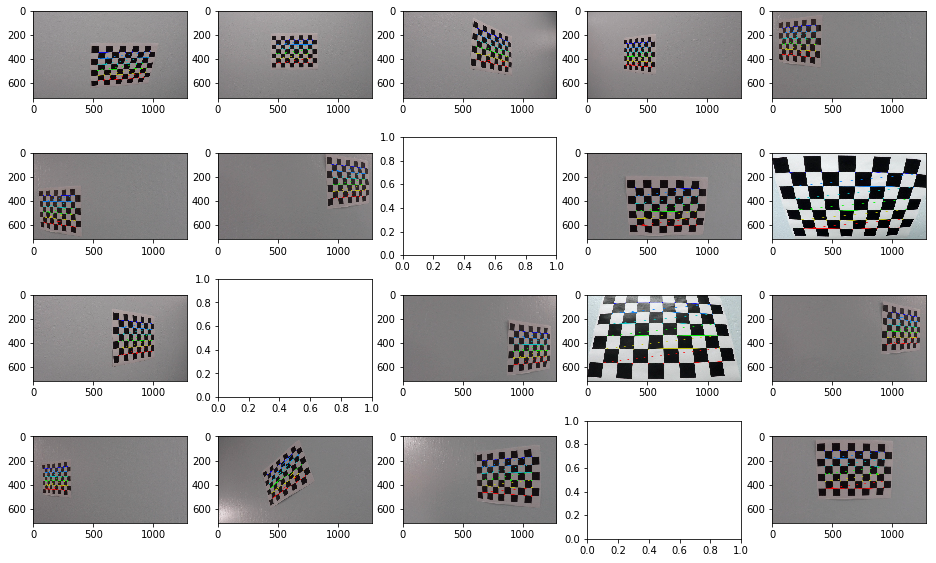

In [2]:
'''
This function calculates corners of the chessboard

Input: 
nx: the number of inside corners in x axis
ny: the number of inside corners in y axis

Output:
objpoints: Object points in 3D space
imgpoints: Image points in 2D space (aka Corners in the image)
'''
def calculate_chessboard_corners(nx, ny):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    objpoints = []
    imgpoints = []

    input_dir = 'camera_cal/'
    output_dir= 'camera_cal_output/'
    f, ax = plt.subplots(4, 5, figsize=(16,10))
    ax = ax.ravel()
    for idx, fname in enumerate(os.listdir(input_dir)):

        img = cv2.imread(input_dir+fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            objpoints+=[objp]
            imgpoints+=[corners]
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            ax[idx].imshow(img)
    plt.show()
    
    return objpoints, imgpoints
    

objpoints, imgpoints = calculate_chessboard_corners(9, 6)

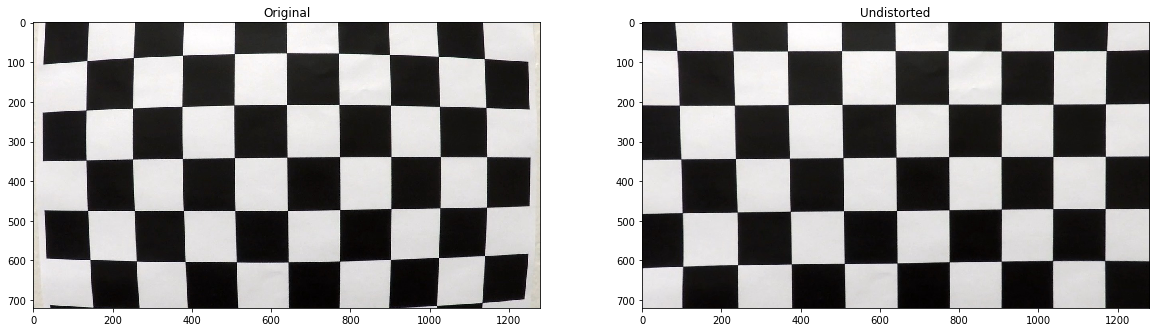

In [12]:
'''
This function undistorts a given image

User has the option of displaying the image and saving the model as well

'''

def display_images(img1, img2, title1, title2, gray=False, gray1=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
    if gray1:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    
    ax1.set_title(title1)
    
    if gray:
        ax2.imshow(img2, cmap='gray')
    else:
        ax2.imshow(img2)
    ax2.set_title(title2)
    plt.show()

def save_step(obj, title):
    dt = date.today()
    tstr = time.strftime("%H%M%S", time.gmtime(666))
    pickle.dump( obj, open( '%s_%s_%s_%s_%s.pkl' % (title, dt.month, dt.day, dt.year, tstr), "wb" ) )
    
def get_image(file_name):
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    
def undistort(img, display=True, save=True):
    img_size = (img.shape[1], img.shape[0])

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)                 
                     
    if display:
        display_images(img, dst, 'Original', 'Undistorted')
    if save:
        save_step({"mtx": mtx, "dist": dist}, 'undistort')
    return dst


result = undistort(get_image('./camera_cal/calibration1.jpg'), True, False)

In [13]:
def get_perspective_transform_points(img, display = True):
    h, w= (img.shape[0], img.shape[1])

    src = np.float32([(600,450),(750,454), (250,680), (1100,680)])
    dst = np.float32([(400,0),(w-400,0),(400,h),(w-400,h)])
    
    if display:
        x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
        y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
        plt.plot(x, y, color='blue', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
        plt.imshow(img)
        plt.title("Perspective Transform Region")
        plt.show()
    return src, dst

In [14]:
def perspective_transform(img, src_pts, dest_pts, display=True, save=True):
    img_size = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(src_pts, dest_pts)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if display:
        display_images(img, warped, "Original", "Perspective Transform")
    
    if save:
        save_step({"M": M}, "perspective_transform")
    return warped, M

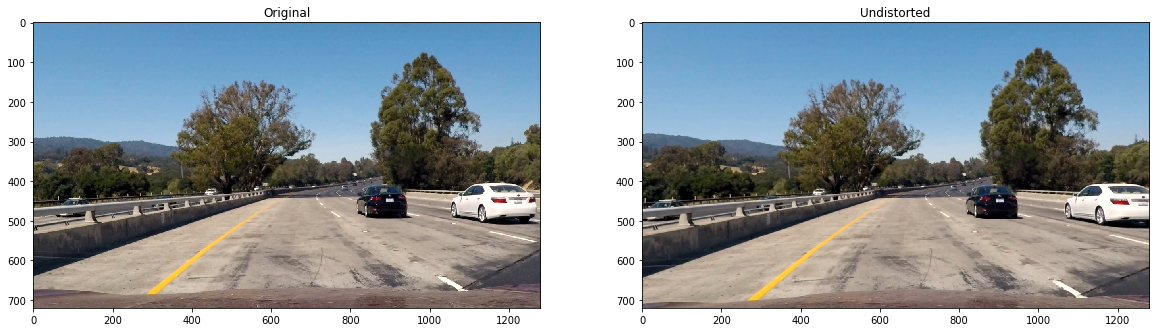

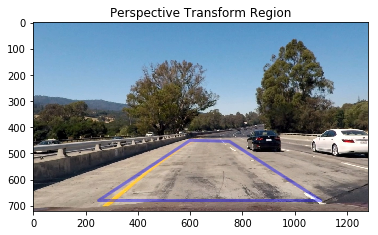

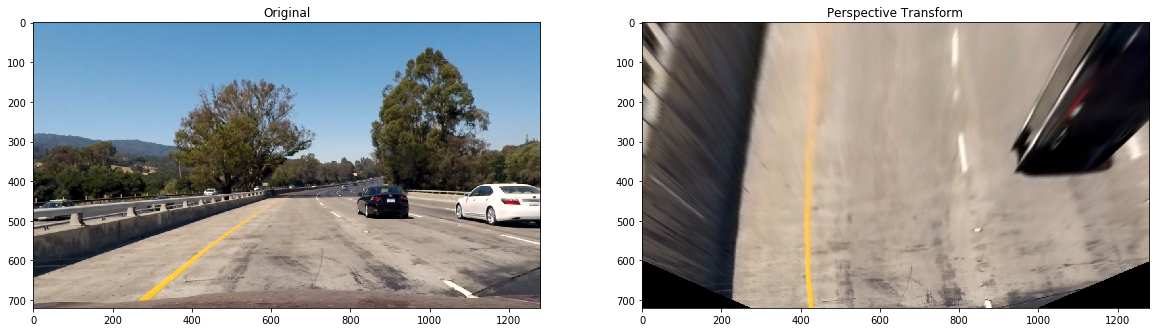

In [15]:
filename = './test_images/test1.jpg'
img = get_image(filename)
undistorted_img = undistort(img, True, False)
src_pts, dest_pts = get_perspective_transform_points(undistorted_img)
perspective_img, M = perspective_transform(undistorted_img, src_pts, dest_pts)

In [16]:
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255, display= True, gray=True):
    
    # Apply the following steps to img
    
    # 1) Convert to grayscale
    if gray:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    if display:
        display_images(img, binary_output, "Original", "Absolute Sobel Threshold Orientation: "+orient, True)
    
    return binary_output

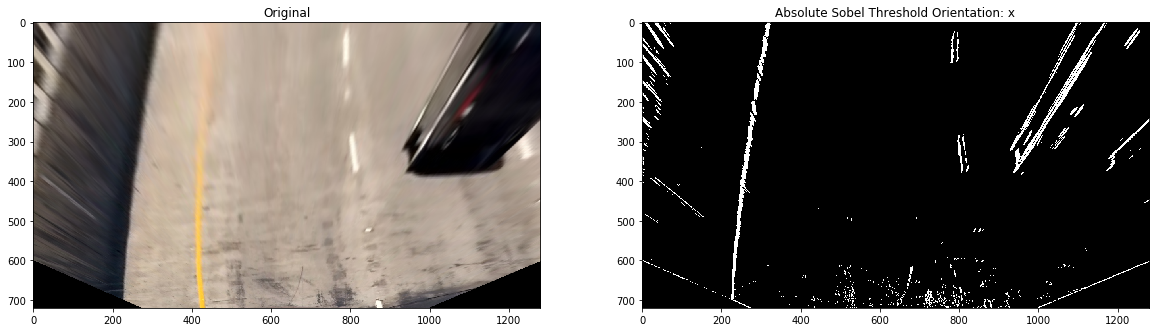

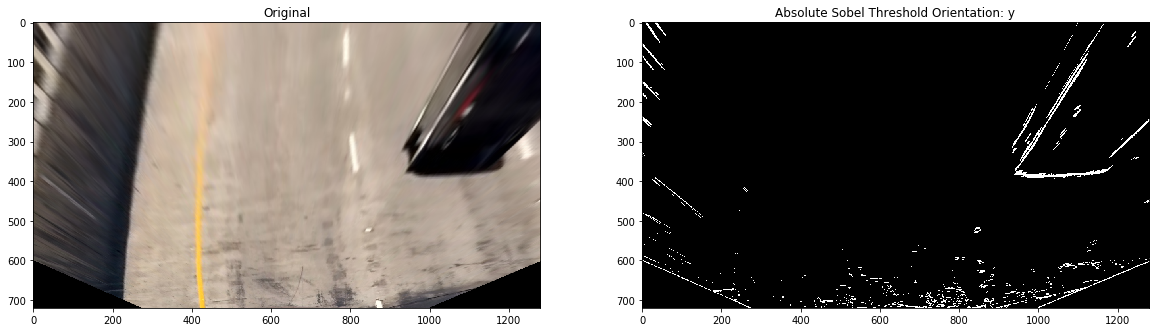

In [17]:
binary_output_img_1 = abs_sobel_thresh(perspective_img, orient='x')
binary_output_img_2 = abs_sobel_thresh(perspective_img, orient='y')

In [25]:
def mag_thresh(img, sobel_kernel=25, mag_thresh=(10, 255), display=True):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) 
    
    if display:
        display_images(img, binary_output, "Original", "Sobel with magnitude threshold", True)
    return binary_output

In [ ]:
binary_output_img_3 = mag_thresh(perspective_img)

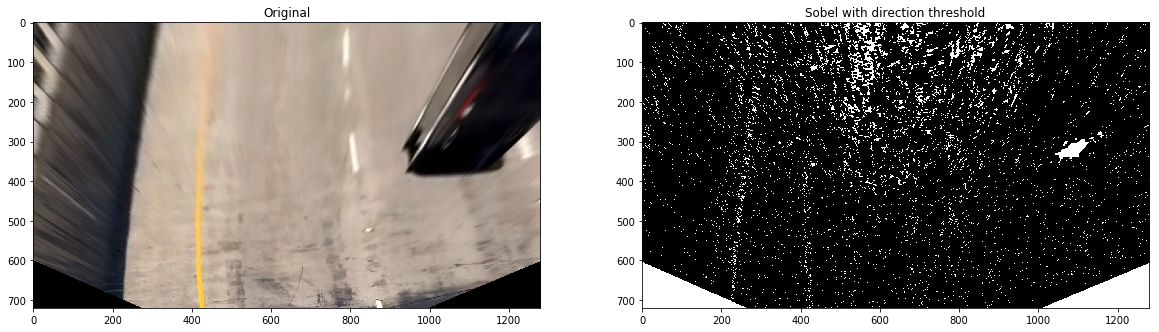

In [19]:
def dir_threshold(img, sobel_kernel=7, thresh=(0, 0.05), display=True):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(graddir)
    # 6) Return this mask as your binary_output image
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    
    if display:
        display_images(img, binary_output, "Original", "Sobel with direction threshold", True)
    return binary_output


binary_output_img_3 = dir_threshold(perspective_img)

In [18]:
def combined_thresholds(grad, mag_binary, dir_binary, display=True ):
    combined = np.zeros_like(dir_binary)
    combined[ (grad == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    if display:
        display_images(img, combined, "Original", "Combined Sobel Image", True)
    return combined

In [19]:
def threshold_color(img, transform, thresh=(0, 255), display=True):
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(img)
    binary_output[(img> thresh[0]) & (img<=thresh[1])] = 1
    
    if display:
        display_images(img, binary_output, transform+" Transform ", transform+" Transform With Threshold", True, False)
    return binary_output


def hls_select(img, idx, transform, display=True):
    hlsimg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    color_output = hlsimg[:,:,idx]
    
    if display:
        display_images(img, color_output, "Original", transform+" Transform", True)
    return color_output


def lab_select(img, idx, transform, display=True):
    labimg = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    color_output = labimg[:,:,idx]

    if display:
        display_images(img, color_output, "Original", transform+" Transform", True)
    return color_output


def rgb_select(img, idx, transform, display=True):
    color_output = img[:,:,idx]
    
    if display:
        display_images(img, color_output, "Original", transform+" Transform", True)
    return color_output

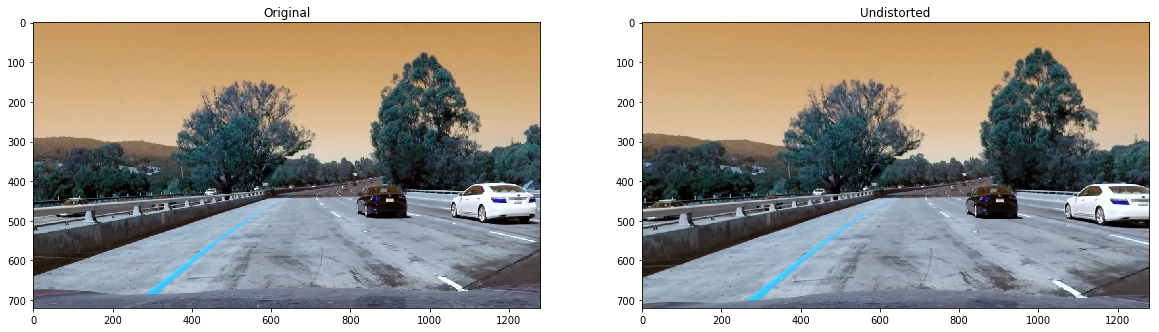

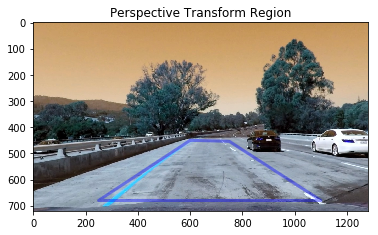

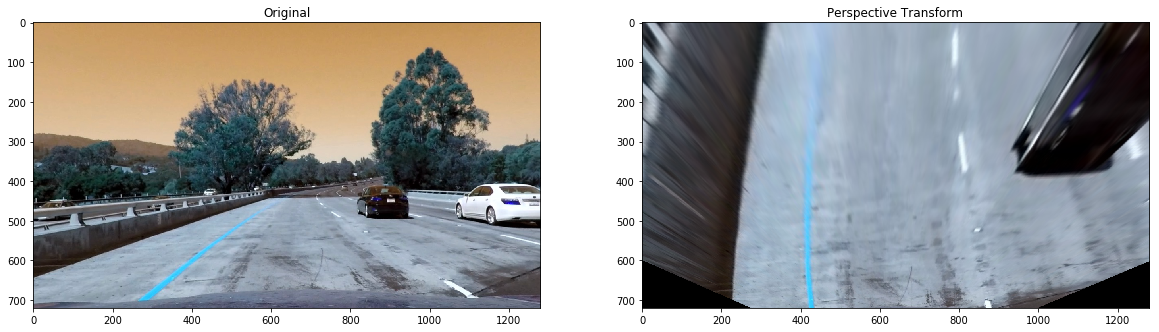

NameError: name 'abs_sobel_thresh' is not defined

In [8]:
filename = './test_images/test1.jpg'
img = get_image(filename)
undistorted_img = undistort(img, True, False)
src_pts, dest_pts = get_perspective_transform_points(undistorted_img)

perspective_img, M = perspective_transform(undistorted_img, src_pts, dest_pts)
binary_output_img_1 = abs_sobel_thresh(perspective_img)
binary_output_img_1 = abs_sobel_thresh(perspective_img, orient='y')
binary_output_img_2 = mag_thresh(perspective_img)
binary_output_img_3 = dir_threshold(perspective_img)
combined_output_img = combined_thresholds(binary_output_img_1, binary_output_img_2, binary_output_img_3)

r_img = threshold_color(rgb_select(perspective_img, 0, "R"), "R", (200, 255))
g_img = threshold_color(rgb_select(perspective_img, 1, "G"), "G", (125, 200))
b_img = threshold_color(rgb_select(perspective_img, 2, "B"), "B", (0, 125))

h_img = threshold_color(hls_select(perspective_img, 0, "H"), "H", (15, 100) )
l_img = threshold_color(hls_select(perspective_img, 1, "L"), "L", (220, 255))
s_img = threshold_color(hls_select(perspective_img, 2, "S"), "S", (125, 255))

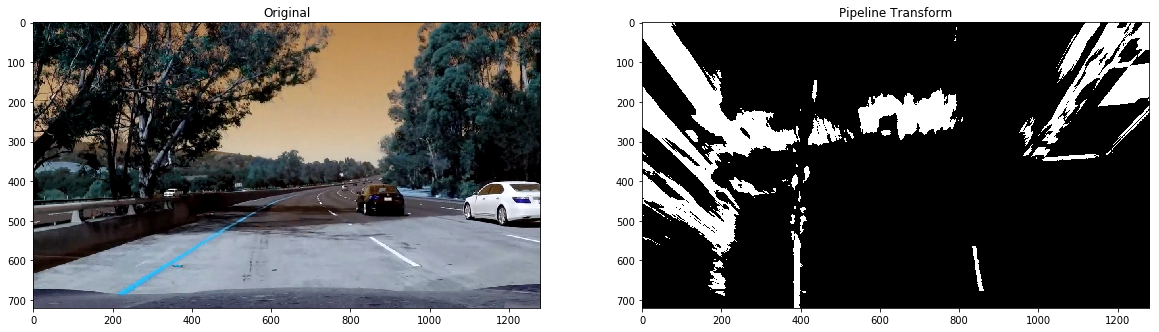

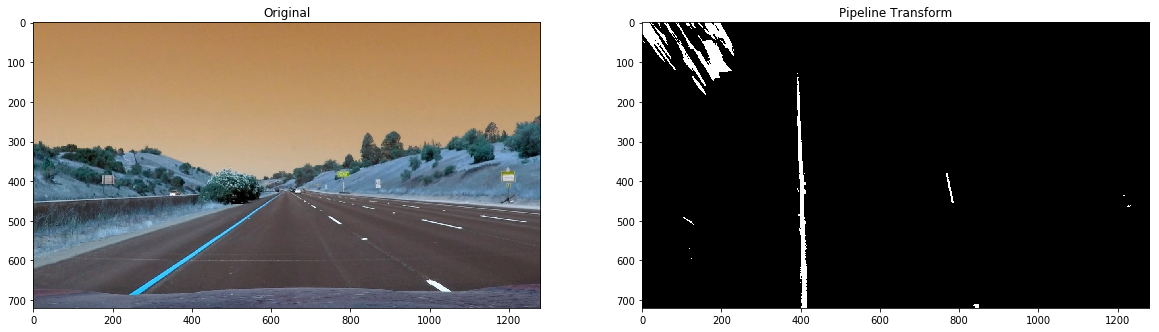

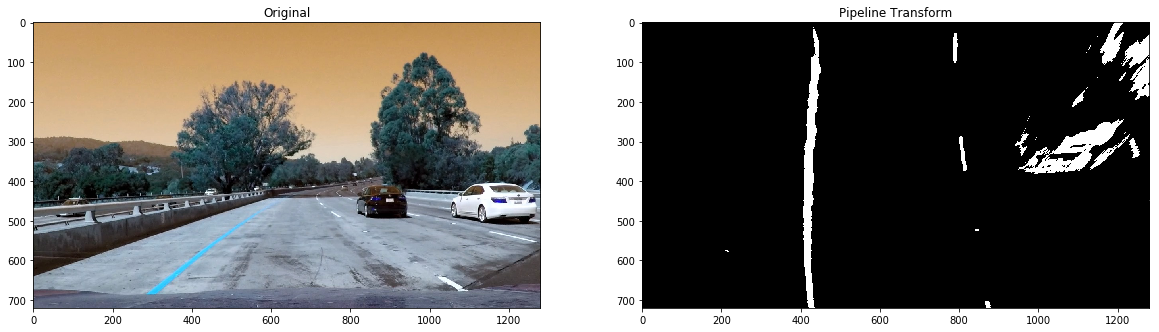

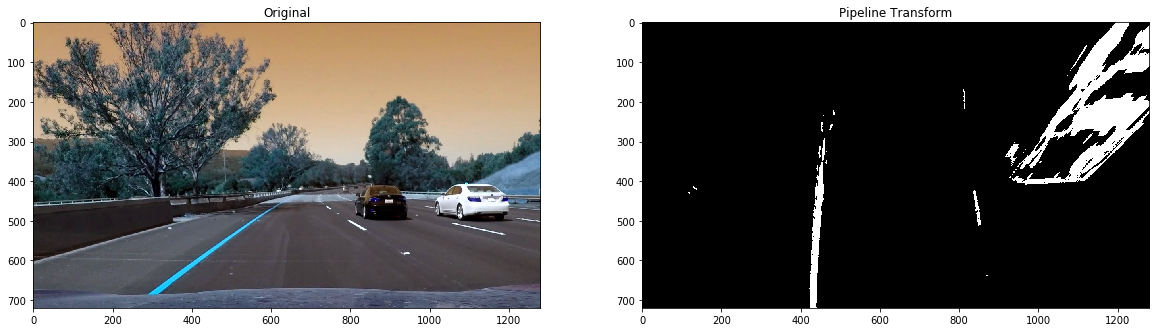

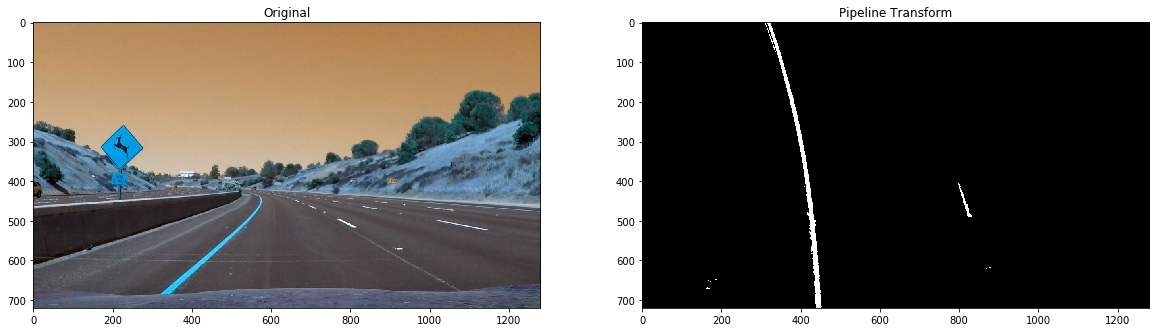

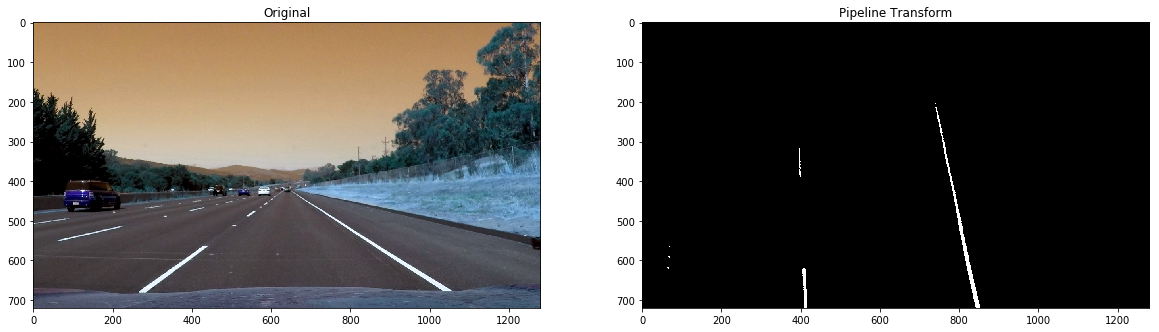

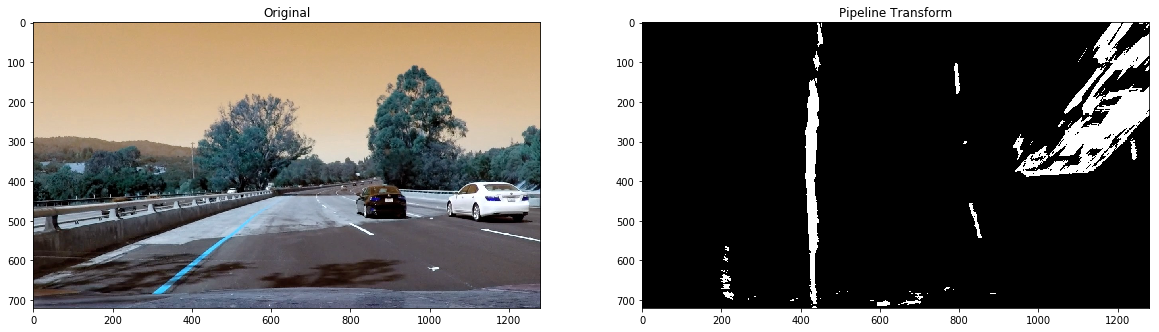

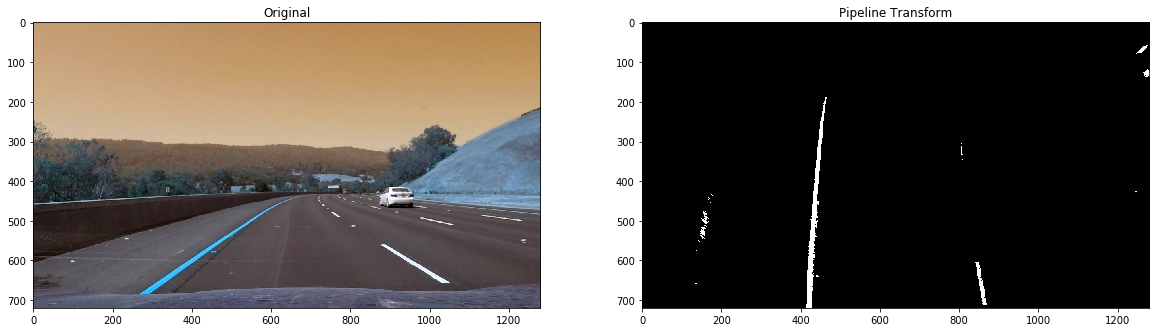

In [45]:
def pipeline(filename):
    img = get_image(filename)
    undistorted_img = undistort(img, display=False, save=False)
    src_pts, dest_pts = get_perspective_transform_points(undistorted_img, display=False)
    
    perspective_img, M = perspective_transform(undistorted_img, src_pts, dest_pts, display=False)
    
 
    s_img = threshold_color(hls_select(perspective_img, 2, "S", display=False), "S", (125, 255), display=False)
    s_img = threshold_color(hls_select(perspective_img, 2, "S", display=False), "S", (125, 255), display=False)
    
    #result = np.zeros_like(s_img)
    #result[(binary_output_img_1 == 1) | (s_img == 1)] = 1
    return s_img


test_image_directory = './test_images'
for idx, fname in enumerate(os.listdir(test_image_directory)):
    fpath = test_image_directory+"/"+fname
    output_img = pipeline(fpath)
    display_images(get_image(fpath), output_img, "Original", "Pipeline Transform", True)

In [13]:
'''
Sliding Window Code
'''

# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        print("Window: ") 
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(pipeline(filename))

Modifying window  1 / 9
Modifying window  2 / 9
Modifying window  3 / 9
Modifying window  4 / 9
Modifying window  5 / 9
Modifying window  6 / 9
Modifying window  7 / 9
Modifying window  8 / 9


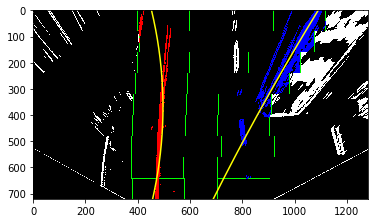

In [14]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()